In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import models
import string
import re
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2]:
data = pd.read_json("./Home_and_Kitchen_5.json", lines=True) # 读取数据
data.drop(columns=["asin", "reviewerName", "helpful", "summary", "unixReviewTime", "reviewTime"], inplace=True) # 删去用不到的列

In [3]:
def tokenization(text): # word tokenization
    text = re.sub(f"[{string.punctuation}]", " ", text).strip().lower() # 去除标点空格还有小写化
    return text.split()

In [4]:
data["corpus"] = data["reviewText"].apply(tokenization)
data["word_count"] = data["corpus"].apply(lambda x: len(x))

In [5]:
data

,reviewerID,reviewText,overall,corpus,word_count
0,APYOBQE6M18AA,My daughter wanted this book and the price on ...,5,"[my, daughter, wanted, this, book, and, the, p...",30
1,A1JVQTAGHYOL7F,I bought this zoku quick pop for my daughterr ...,5,"[i, bought, this, zoku, quick, pop, for, my, d...",26
2,A3UPYGJKZ0XTU4,There is no shortage of pop recipes available ...,4,"[there, is, no, shortage, of, pop, recipes, av...",415
3,A2MHCTX43MIMDZ,This book is a must have if you get a Zoku (wh...,5,"[this, book, is, a, must, have, if, you, get, ...",64
4,AHAI85T5C2DH3,This cookbook is great. I have really enjoyed...,4,"[this, cookbook, is, great, i, have, really, e...",97
...,...,...,...,...,...
551677,A11J1FHCK5U06J,These ice pop molds are awesome! Bright kid-ha...,5,"[these, ice, pop, molds, are, awesome, bright,...",102
551678,A537XC69FAD3J,great popsicle molds - very nice quality - and...,5,"[great, popsicle, molds, very, nice, quality, ...",13
551679,AWHZOUIQ0VO7M,My kids and I are loving these - putting our c...,5,"[my, kids, and, i, are, loving, these, putting...",15
551680,A1KQNP8MOJDJKC,"I love these ice pop makers. First off, I love...",5,"[i, love, these, ice, pop, makers, first, off,...",104


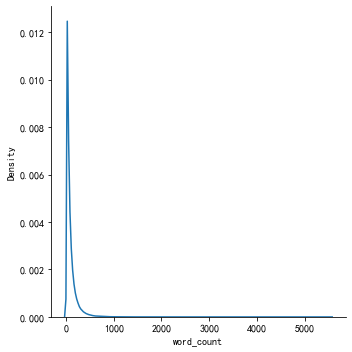

In [6]:
sns.displot(data["word_count"], kind="kde") # 词数的分布
plt.show()

In [7]:
w2vmodel = models.Word2Vec(sentences=data["corpus"].tolist(), vector_size=100, window=5, min_count=0, workers=4) # 训练word2vec模型

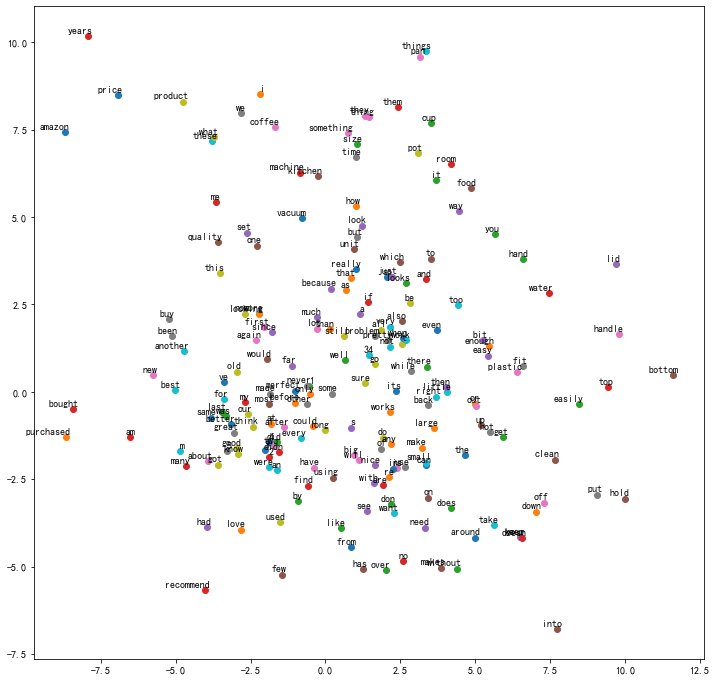

In [8]:
# 训练完毕后运行以下代码可以可视化word2vec模型的结果，即单词的语义空间。
W = list(map(lambda x: w2vmodel.wv[x], w2vmodel.wv.index_to_key))
pca = PCA(n_components=2) # 降维 方便可视化
W = pca.fit_transform(W)
plt.figure(figsize=(12, 12))
for i, label in enumerate(w2vmodel.wv.index_to_key[:200]):
    x, y = W[i][0], W[i][1]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [9]:
def calc_vector(c, w2vmodel=w2vmodel): # 根据word2vec表示句子
    res = np.zeros(100)
    for word in c:
        res += w2vmodel.wv[word]
    return res / len(c)


In [10]:
corpus = data["corpus"].tolist()
vectors = list(map(lambda x: calc_vector(x), corpus))

D:\Temp/ipykernel_20464/3484296795.py:5: RuntimeWarning: invalid value encountered in true_divide
  return res / len(c)


In [11]:
vectors = np.array(vectors)
vectors.shape

(551682, 100)

In [12]:
y = data["overall"].values

In [13]:
temp_data = pd.DataFrame(vectors)

In [14]:
temp_data["label"] = y
temp_data.dropna(inplace=True)

In [15]:
X = temp_data.drop(columns=["label"]).values
y = temp_data["label"].values
# 构造数据集

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 分割数据集

In [17]:
train_sizes, train_loss, test_loss = learning_curve(SVC(kernel="rbf", C=1, gamma=0.1), X_train, y_train, cv=5, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) # 训练数据并计算损失

In [ ]:
train_mean = -np.mean(train_loss,axis=1)
test_mean = -np.mean(test_loss,axis=1)

In [ ]:
plt.plot(train_sizes,train_mean,label="Training")
plt.plot(train_sizes,test_mean,label="Cross-validation")
plt.legend()
plt.show()
# 可视化训练数据的损失